# Region Segmentation Using Traditional Techniques

In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/MSFD.zip"

with ZipFile(file_name, 'r') as zip_file:
  zip_file.extractall()
  print('Done')


Done


In [ ]:
!pip install opencv-python



Processing images with traditional segmentation techniques...


100%|██████████| 9382/9382 [03:53<00:00, 40.21it/s]



Results Summary:
Average Accuracy: 0.5106
Average Dice Score: 0.3973
Average IoU Score: 0.2835


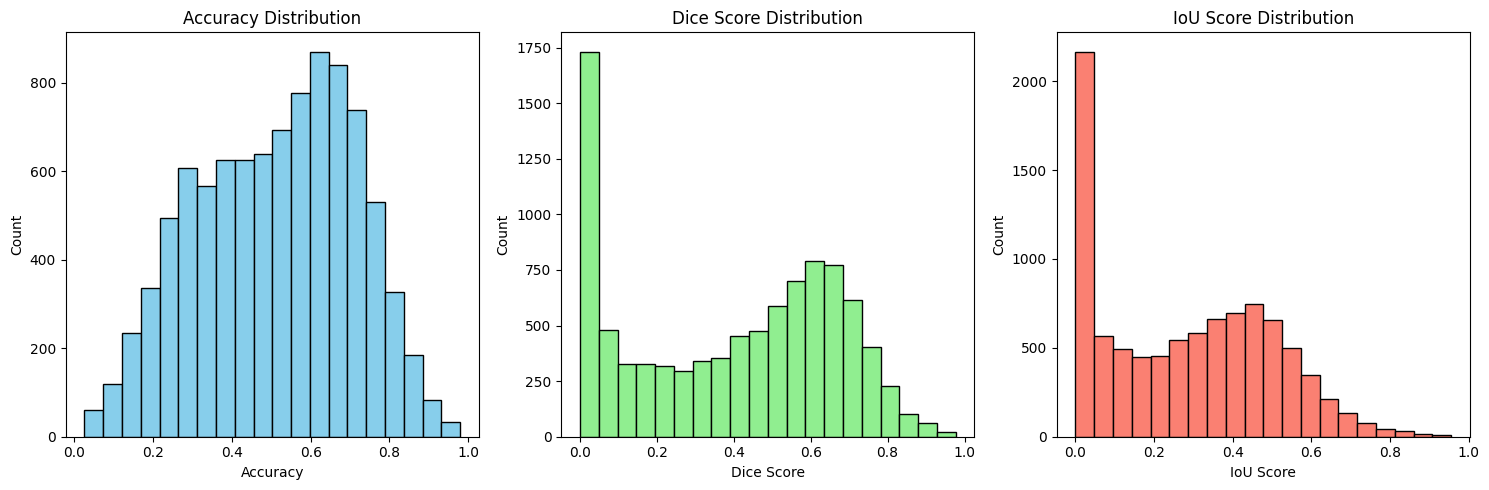

All segmentation outputs and evaluation results saved to segmented_outputs_task_c


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


# Set paths
base_dir = "/content/MSFD/1"  # Change to actual dataset path
input_dir = os.path.join(base_dir, "face_crop")
mask_dir = os.path.join(base_dir, "face_crop_segmentation")  # Ground truth masks
output_dir = "segmented_outputs_task_c"  # Output folder for traditional segmentation

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get list of images
image_names = os.listdir(input_dir)
image_paths = [os.path.join(input_dir, name) for name in image_names]
mask_paths = [os.path.join(mask_dir, name) for name in image_names]

# Filter to make sure both image and mask exist
valid_pairs = [(img, mask) for img, mask in zip(image_paths, mask_paths) if os.path.exists(img) and os.path.exists(mask)]
image_paths, mask_paths = zip(*valid_pairs)

# Define image dimensions
img_height = 128
img_width = 128

# Traditional Segmentation Function
def segment_mask(image_path):
    """Applies traditional segmentation techniques to segment the face mask region."""
    # Load image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (img_width, img_height))

    # Convert to grayscale
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's Thresholding
    _, binary_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Morphological Operations (Closing to refine mask)
    kernel = np.ones((3,3), np.uint8)
    mask_segmented = cv2.morphologyEx(binary_thresh, cv2.MORPH_CLOSE, kernel)

    return gray, binary_thresh, edges, mask_segmented

# Evaluation Metrics
def dice_coef(y_true, y_pred, smooth=1):
    """Calculates Dice Score."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Calculates IoU Score."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred):
    """Computes accuracy, Dice, and IoU scores."""
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    accuracy = np.mean(y_true == y_pred_binary)
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    return accuracy, dice, iou

# Process All Images and Compute Metrics
results = []
print("Processing images with traditional segmentation techniques...")

for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
    filename = os.path.basename(img_path)

    # Apply segmentation techniques
    gray, binary_thresh, edges, mask_segmented = segment_mask(img_path)

    # Load ground truth mask
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (img_width, img_height))
    true_mask_binary = (true_mask_resized > 128).astype(np.float32)  # Binarize

    # Compute metrics
    acc, dice, iou = calculate_metrics(true_mask_binary, mask_segmented)

    results.append({
        'filename': filename,
        'accuracy': acc,
        'dice_score': dice,
        'iou_score': iou
    })

    # Save the segmentation result
    save_path = os.path.join(output_dir, f"segmented_{filename}")
    cv2.imwrite(save_path, mask_segmented)

    # Visualize & Save comparison every 20 images
    if len(results) % 20 == 0:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale")

        plt.subplot(1, 4, 2)
        plt.imshow(binary_thresh, cmap='gray')
        plt.title("Thresholding")

        plt.subplot(1, 4, 3)
        plt.imshow(edges, cmap='gray')
        plt.title("Edge Detection")

        plt.subplot(1, 4, 4)
        plt.imshow(mask_segmented, cmap='gray')
        plt.title(f"Segmented Mask\nIoU: {iou:.4f}, Dice: {dice:.4f}")

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'comparison_{filename}.png'))
        plt.close()

# Compile results into DataFrame and save
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(f"Average Accuracy: {results_df['accuracy'].mean():.4f}")
print(f"Average Dice Score: {results_df['dice_score'].mean():.4f}")
print(f"Average IoU Score: {results_df['iou_score'].mean():.4f}")

# Save metrics to CSV
results_df.to_csv(os.path.join(output_dir, 'segmentation_metrics_task_c.csv'), index=False)

# Plot distribution of metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(results_df['accuracy'], bins=20, color='skyblue', edgecolor='black')
plt.title('Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(results_df['dice_score'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Dice Score Distribution')
plt.xlabel('Dice Score')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(results_df['iou_score'], bins=20, color='salmon', edgecolor='black')
plt.title('IoU Score Distribution')
plt.xlabel('IoU Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metrics_distribution_task_c.png'))
plt.show()

print(f"All segmentation outputs and evaluation results saved to {output_dir}")


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


# Set paths
base_dir = "/content/MSFD/1"  
input_dir = os.path.join(base_dir, "face_crop")
mask_dir = os.path.join(base_dir, "face_crop_segmentation")  # Ground truth masks
output_dir = "segmented_outputs_task_c_extended"  # Output folder

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get list of images
image_names = os.listdir(input_dir)
image_paths = [os.path.join(input_dir, name) for name in image_names]
mask_paths = [os.path.join(mask_dir, name) for name in image_names]

# Filter valid pairs
valid_pairs = [(img, mask) for img, mask in zip(image_paths, mask_paths) if os.path.exists(img) and os.path.exists(mask)]
image_paths, mask_paths = zip(*valid_pairs)

# Define image dimensions
img_height = 128
img_width = 128


# Traditional Segmentation Function
def segment_mask(image_path):
    """Applies different traditional segmentation techniques."""
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (img_width, img_height))

    # Convert to grayscale
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 1️⃣ Otsu's Thresholding
    _, binary_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 2️⃣ Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # 3️⃣ Morphological Closing (Filling small holes)
    kernel = np.ones((3,3), np.uint8)
    morph_closed = cv2.morphologyEx(binary_thresh, cv2.MORPH_CLOSE, kernel)

    # 4️⃣ Watershed Algorithm
    markers = np.zeros_like(gray, dtype=np.int32)
    markers[gray < 50] = 1  # Background
    markers[gray > 200] = 2  # Foreground
    cv2.watershed(img_resized, markers)
    watershed_seg = (markers == 2).astype(np.uint8) * 255

    # 5️⃣ GrabCut Foreground Segmentation
    mask_grabcut = np.zeros(img_resized.shape[:2], np.uint8)
    rect = (10, 10, img_width - 10, img_height - 10)  # Initial bounding box
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(img_resized, mask_grabcut, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    grabcut_seg = np.where((mask_grabcut == 2) | (mask_grabcut == 0), 0, 255).astype(np.uint8)

    return gray, binary_thresh, edges, morph_closed, watershed_seg, grabcut_seg


# Process All Images
results = []
print("Processing images with multiple segmentation techniques...")

for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
    filename = os.path.basename(img_path)

    # Apply segmentation techniques
    gray, binary_thresh, edges, morph_closed, watershed_seg, grabcut_seg = segment_mask(img_path)

    # Save results
    save_paths = {
        "threshold": os.path.join(output_dir, f"threshold_{filename}"),
        "edges": os.path.join(output_dir, f"edges_{filename}"),
        "morph_closed": os.path.join(output_dir, f"morph_{filename}"),
        "watershed": os.path.join(output_dir, f"watershed_{filename}"),
        "grabcut": os.path.join(output_dir, f"grabcut_{filename}")
    }

    cv2.imwrite(save_paths["threshold"], binary_thresh)
    cv2.imwrite(save_paths["edges"], edges)
    cv2.imwrite(save_paths["morph_closed"], morph_closed)
    cv2.imwrite(save_paths["watershed"], watershed_seg)
    cv2.imwrite(save_paths["grabcut"], grabcut_seg)

    # Visualize & Save Comparison
    if len(results) % 20 == 0:
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 3, 1)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale")

        plt.subplot(2, 3, 2)
        plt.imshow(binary_thresh, cmap='gray')
        plt.title("Thresholding")

        plt.subplot(2, 3, 3)
        plt.imshow(edges, cmap='gray')
        plt.title("Edge Detection")

        plt.subplot(2, 3, 4)
        plt.imshow(morph_closed, cmap='gray')
        plt.title("Morphological Closing")

        plt.subplot(2, 3, 5)
        plt.imshow(watershed_seg, cmap='gray')
        plt.title("Watershed Segmentation")

        plt.subplot(2, 3, 6)
        plt.imshow(grabcut_seg, cmap='gray')
        plt.title("GrabCut Segmentation")

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'comparison_{filename}.png'))
        plt.close()

print(f"All segmentation outputs saved to {output_dir}")


Processing images with multiple segmentation techniques...


100%|██████████| 9382/9382 [2:05:09<00:00,  1.25it/s]

All segmentation outputs saved to segmented_outputs_task_c_extended


Evaluating segmentation results...


100%|██████████| 9382/9382 [00:13<00:00, 675.71it/s]


Metrics saved to segmented_outputs_task_c_extended/segmentation_metrics_task_c_extended.csv

Results Summary:
              accuracy  dice_score  iou_score
method                                       
edges         0.648956    0.161990   0.091862
grabcut       0.718067    0.672323   0.540645
morph_closed  0.510575    0.397349   0.283493
threshold     0.511416    0.394348   0.281106
watershed     0.551275    0.370153   0.277277


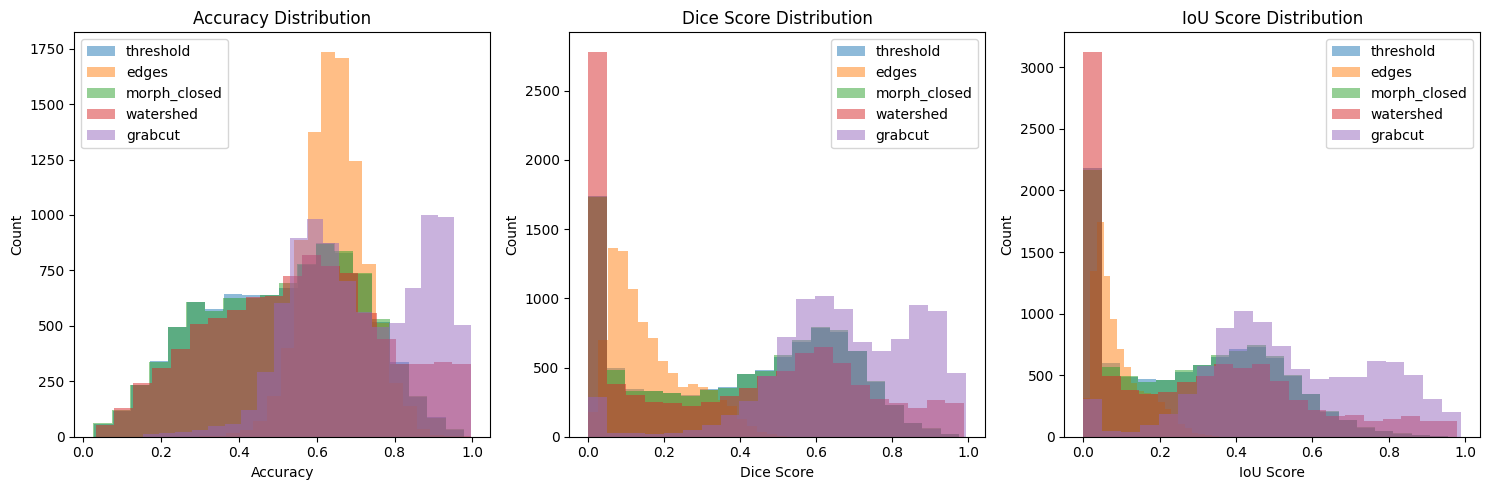

All evaluation results saved to segmented_outputs_task_c_extended


In [ ]:
# Evaluation Metrics
def dice_coef(y_true, y_pred, smooth=1):
    """Calculates Dice Score."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Calculates IoU Score."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy_score(y_true, y_pred):
    """Computes pixel-wise accuracy."""
    return np.mean(y_true == y_pred)

def calculate_metrics(y_true, y_pred):
    """Computes Accuracy, Dice, and IoU scores."""
    y_pred_binary = (y_pred > 128).astype(np.float32)  # Convert to binary mask

    acc = accuracy_score(y_true, y_pred_binary)
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)

    return acc, dice, iou

# Process All Images and Compute Metrics
results = []
print("Evaluating segmentation results...")

for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
    filename = os.path.basename(img_path)

    # Load ground truth mask
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (img_width, img_height))
    true_mask_binary = (true_mask_resized > 128).astype(np.float32)  # Binarize

    # Load segmented masks
    segmented_masks = {
        "threshold": cv2.imread(os.path.join(output_dir, f"threshold_{filename}"), cv2.IMREAD_GRAYSCALE),
        "edges": cv2.imread(os.path.join(output_dir, f"edges_{filename}"), cv2.IMREAD_GRAYSCALE),
        "morph_closed": cv2.imread(os.path.join(output_dir, f"morph_{filename}"), cv2.IMREAD_GRAYSCALE),
        "watershed": cv2.imread(os.path.join(output_dir, f"watershed_{filename}"), cv2.IMREAD_GRAYSCALE),
        "grabcut": cv2.imread(os.path.join(output_dir, f"grabcut_{filename}"), cv2.IMREAD_GRAYSCALE)
    }

    # Compute metrics for each method
    for method, pred_mask in segmented_masks.items():
        if pred_mask is not None:
            acc, dice, iou = calculate_metrics(true_mask_binary, pred_mask)

            results.append({
                'filename': filename,
                'method': method,
                'accuracy': acc,
                'dice_score': dice,
                'iou_score': iou
            })


# Convert evaluation results into a DataFrame
results_df = pd.DataFrame(results)

# Ensure numeric values for aggregation
results_df[["accuracy", "dice_score", "iou_score"]] = results_df[["accuracy", "dice_score", "iou_score"]].apply(pd.to_numeric)

# Save metrics to CSV
metrics_path = os.path.join(output_dir, 'segmentation_metrics_task_c_extended.csv')
results_df.to_csv(metrics_path, index=False)
print(f"Metrics saved to {metrics_path}")

# Compute summary statistics
summary_df = results_df.groupby("method")[["accuracy", "dice_score", "iou_score"]].mean()
print("\nResults Summary:")
print(summary_df)


# Plot distribution of metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method in results_df["method"].unique():
    plt.hist(results_df[results_df["method"] == method]["accuracy"], bins=20, alpha=0.5, label=method)
plt.title('Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 2)
for method in results_df["method"].unique():
    plt.hist(results_df[results_df["method"] == method]["dice_score"], bins=20, alpha=0.5, label=method)
plt.title('Dice Score Distribution')
plt.xlabel('Dice Score')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 3)
for method in results_df["method"].unique():
    plt.hist(results_df[results_df["method"] == method]["iou_score"], bins=20, alpha=0.5, label=method)
plt.title('IoU Score Distribution')
plt.xlabel('IoU Score')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metrics_distribution_task_c_extended.png'))
plt.show()

print(f"All evaluation results saved to {output_dir}")


Processing images using optimized K-Means clustering with preprocessing...


100%|██████████| 9382/9382 [04:48<00:00, 32.53it/s]


Metrics saved to segmented_outputs_kmeans_optimized/segmentation_metrics_kmeans_optimized.csv

Results Summary:
accuracy      0.479299
dice_score    0.363973
iou_score     0.252885
dtype: float64


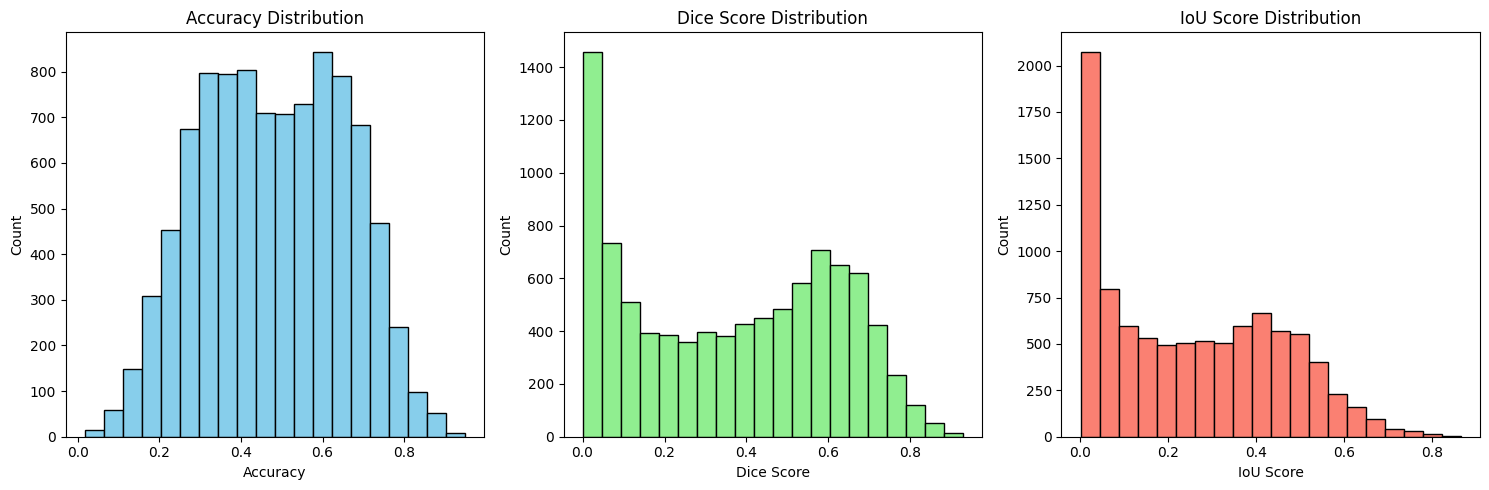

All evaluation results saved to segmented_outputs_kmeans_optimized


In [ ]:
# import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from concurrent.futures import ThreadPoolExecutor

# Set paths
base_dir = "/content/MSFD/1"  # Change to actual dataset path
input_dir = os.path.join(base_dir, "face_crop")
mask_dir = os.path.join(base_dir, "face_crop_segmentation")  # Ground truth masks
output_dir = "segmented_outputs_kmeans_optimized"  # Output folder

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get list of images
image_names = os.listdir(input_dir)
image_paths = [os.path.join(input_dir, name) for name in image_names]
mask_paths = [os.path.join(mask_dir, name) for name in image_names]

# Filter valid pairs
valid_pairs = [(img, mask) for img, mask in zip(image_paths, mask_paths) if os.path.exists(img) and os.path.exists(mask)]
image_paths, mask_paths = zip(*valid_pairs)

# Define image dimensions
img_height = 128
img_width = 128

# Preprocessing Function
def preprocess_image(image_path):
    """Applies preprocessing steps for better K-Means segmentation."""
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_AREA)

    # Convert to LAB Color Space (Better color clustering)
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L-channel (Enhance contrast)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab_enhanced = cv2.merge([l, a, b])
    img_clahe = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    # Apply Gaussian Blurring (Reduce noise)
    img_blurred = cv2.GaussianBlur(img_clahe, (5,5), 0)

    return img_blurred

# K-Means Clustering with Preprocessing
def fast_kmeans_segmentation(image_path, k=2):
    """Performs fast K-Means clustering-based segmentation with preprocessing."""
    img_preprocessed = preprocess_image(image_path)

    # Reshape image into a 2D array (faster processing)
    pixels = img_preprocessed.reshape(-1, 3)

    # Apply MiniBatch K-Means (Faster than normal K-Means)
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=500)
    labels = kmeans.fit_predict(pixels)

    # Reshape labels back to image shape
    segmented_image = labels.reshape(img_height, img_width)

    # Convert to binary mask (assigning one cluster as mask)
    mask = (segmented_image == segmented_image[0, 0]).astype(np.uint8) * 255

    # Apply Morphological Closing (Remove small holes)
    kernel = np.ones((3,3), np.uint8)
    mask_morph = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask_morph

# Evaluation Metrics
def dice_coef(y_true, y_pred, smooth=1):
    """Calculates Dice Score."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Calculates IoU Score."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy_score(y_true, y_pred):
    """Computes pixel-wise accuracy."""
    return np.mean(y_true == y_pred)

def calculate_metrics(y_true, y_pred):
    """Computes Accuracy, Dice, and IoU scores."""
    y_pred_binary = (y_pred > 128).astype(np.float32)  # Convert to binary mask

    acc = accuracy_score(y_true, y_pred_binary)
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)

    return acc, dice, iou


# Parallel Processing for Faster Execution
def process_image(img_path, mask_path):
    """Process a single image for segmentation and evaluation in parallel."""
    filename = os.path.basename(img_path)

    # Apply optimized K-Means segmentation
    segmented_mask = fast_kmeans_segmentation(img_path)

    # Load ground truth mask
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (img_width, img_height), interpolation=cv2.INTER_LINEAR)
    true_mask_binary = (true_mask_resized > 128).astype(np.float32)  # Binarize

    # Compute evaluation metrics
    acc, dice, iou = calculate_metrics(true_mask_binary, segmented_mask)

    # Save segmented mask
    save_path = os.path.join(output_dir, f"segmented_{filename}")
    cv2.imwrite(save_path, segmented_mask)

    return {'filename': filename, 'accuracy': acc, 'dice_score': dice, 'iou_score': iou}


# Run Segmentation on All Images in Parallel
results = []
print("Processing images using optimized K-Means clustering with preprocessing...")

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(process_image, image_paths, mask_paths), total=len(image_paths)))

# Save Results
results_df = pd.DataFrame(results)

# Convert metrics to numeric
results_df[["accuracy", "dice_score", "iou_score"]] = results_df[["accuracy", "dice_score", "iou_score"]].apply(pd.to_numeric)

# Save metrics to CSV
metrics_path = os.path.join(output_dir, 'segmentation_metrics_kmeans_optimized.csv')
results_df.to_csv(metrics_path, index=False)
print(f"Metrics saved to {metrics_path}")

# Summary Statistics
print("\nResults Summary:")
summary_df = results_df[["accuracy", "dice_score", "iou_score"]].mean()
print(summary_df)

# Plot Metric Distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(results_df["accuracy"], bins=20, color='skyblue', edgecolor='black')
plt.title('Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(results_df["dice_score"], bins=20, color='lightgreen', edgecolor='black')
plt.title('Dice Score Distribution')
plt.xlabel('Dice Score')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(results_df["iou_score"], bins=20, color='salmon', edgecolor='black')
plt.title('IoU Score Distribution')
plt.xlabel('IoU Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metrics_distribution_kmeans_optimized.png'))
plt.show()

print(f"All evaluation results saved to {output_dir}")


# Mask Segmentation Using U-Net

### First Approach

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import cv2
from tqdm import tqdm
import pandas as pd

In [2]:
gpus = tf.config.list_physical_devices('GPU')       # Setting up GPU
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU is now being used!")
    except RuntimeError as e:
        print(e)

GPU is now being used!


In [ ]:
IMAGE_DIR = r"..\MSFD\MSFD\1\face_crop"         # Setting paths
MASK_DIR = r"..\MSFD\MSFD\1\face_crop_segmentation"

In [ ]:
# Defining image size
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Function to load and preprocess images
def load_data(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    images, masks = [], []

    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Resize
        img = img / 255.0  # Normalize
        images.append(img)

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))  # Resize
        mask = mask / 255.0  # Normalize
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

In [5]:
X, y = load_data(IMAGE_DIR, MASK_DIR)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Define U-Net model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(drop4), conv3], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
# Create and compile model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [8]:
# Define callbacks
checkpoint = ModelCheckpoint('unet_face_mask.keras',
                             monitor='val_loss',
                             save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)


In [ ]:
# Enabling mixed precision training to improve training speed and reduce memory usage -- no effect on accuracy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [ ]:
# Training 

print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Training model...
Epoch 1/20
939/939 [==============================] - 118s 88ms/step - loss: 0.3408 - accuracy: 0.5724 - mean_io_u: 0.4973 - val_loss: 0.3024 - val_accuracy: 0.5885 - val_mean_io_u: 0.4973
Epoch 2/20
939/939 [==============================] - 79s 84ms/step - loss: 0.2960 - accuracy: 0.5784 - mean_io_u: 0.4973 - val_loss: 0.2900 - val_accuracy: 0.5735 - val_mean_io_u: 0.4973
Epoch 3/20
939/939 [==============================] - 79s 84ms/step - loss: 0.2886 - accuracy: 0.5799 - mean_io_u: 0.4973 - val_loss: 0.2866 - val_accuracy: 0.5838 - val_mean_io_u: 0.4973
Epoch 4/20
939/939 [==============================] - 79s 84ms/step - loss: 0.2852 - accuracy: 0.5806 - mean_io_u: 0.4973 - val_loss: 0.2828 - val_accuracy: 0.5784 - val_mean_io_u: 0.4973
Epoch 5/20
939/939 [==============================] - 80s 85ms/step - loss: 0.2831 - accuracy: 0.5808 - mean_io_u: 0.4973 - val_loss: 0.2801 - val_accuracy: 0.5785 - val_mean_io_u: 0.4973
Epoch 6/20
939/939 [=====================

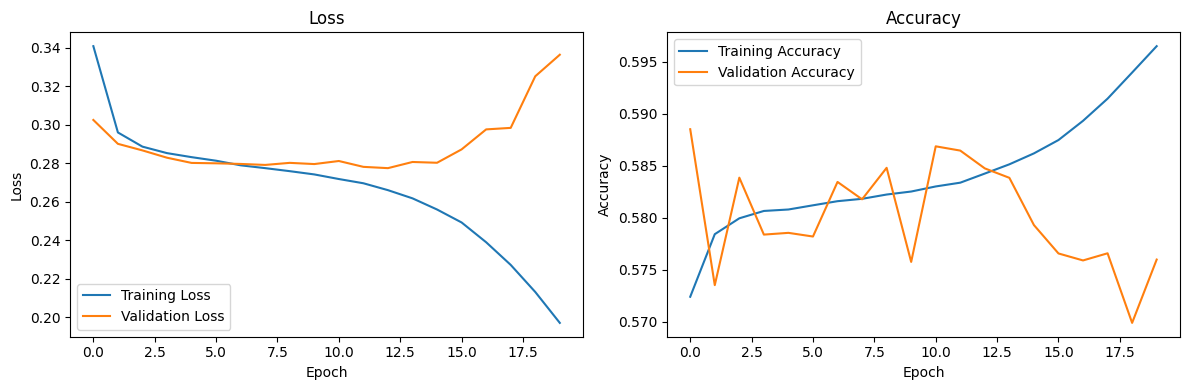

In [ ]:
# Ploting training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [ ]:
# Calculate IOU, Dice Score and Accuracy on validation set
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    
    # Calculate metrics
    accuracy = np.mean(y_true == y_pred_binary)
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    
    return accuracy, dice, iou

In [15]:
# Evaluate on validation set
print("Evaluating model on validation set...")
validation_predictions = model.predict(X_test)
val_accuracy, val_dice, val_iou = calculate_metrics(y_test, validation_predictions)

print(f"Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Dice Score: {val_dice:.4f}")
print(f"IoU Score: {val_iou:.4f}")


Evaluating model on validation set...
59/59 [==============================] - 4s 74ms/step
Validation Metrics:
Accuracy: 0.5760
Dice Score: 0.7921
IoU Score: 0.6558


### Second Approach

In [34]:
X, y = load_data(IMAGE_DIR, MASK_DIR)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
seed = 42
batch_size = 16

In [ ]:
# Improved U-Net Architecture

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, LeakyReLU

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(drop4), conv3], axis=3)
    conv5 = Conv2D(256, 3, padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU()(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=3)
    conv6 = Conv2D(128, 3, padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=3)
    conv7 = Conv2D(64, 3, padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU()(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
# Compile model (using Dice Loss)
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks: Checkpoint, Early Stopping, and LR Scheduler

checkpoint = ModelCheckpoint('unet_face_mask.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# Training

print("Training model...")
steps_per_epoch = len(X_train) // batch_size
history = model.fit(
    X_train, y_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Training model...
Epoch 1/50
469/469 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.5572 - mean_io_u: 0.4972
Epoch 1: val_loss improved from inf to 0.32962, saving model to unet_face_mask.keras
469/469 [==============================] - 129s 214ms/step - loss: 0.3714 - accuracy: 0.5572 - mean_io_u: 0.4972 - val_loss: 0.3296 - val_accuracy: 0.5761 - val_mean_io_u: 0.4973
Epoch 2/50
469/469 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.5748 - mean_io_u: 0.4973
Epoch 2: val_loss improved from 0.32962 to 0.29905, saving model to unet_face_mask.keras
469/469 [==============================] - 95s 203ms/step - loss: 0.3057 - accuracy: 0.5748 - mean_io_u: 0.4973 - val_loss: 0.2990 - val_accuracy: 0.5838 - val_mean_io_u: 0.4973
Epoch 3/50
469/469 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.5770 - mean_io_u: 0.4972
Epoch 3: val_loss improved from 0.29905 to 0.29390, saving model to unet_face_mask.keras
469/469 [=====

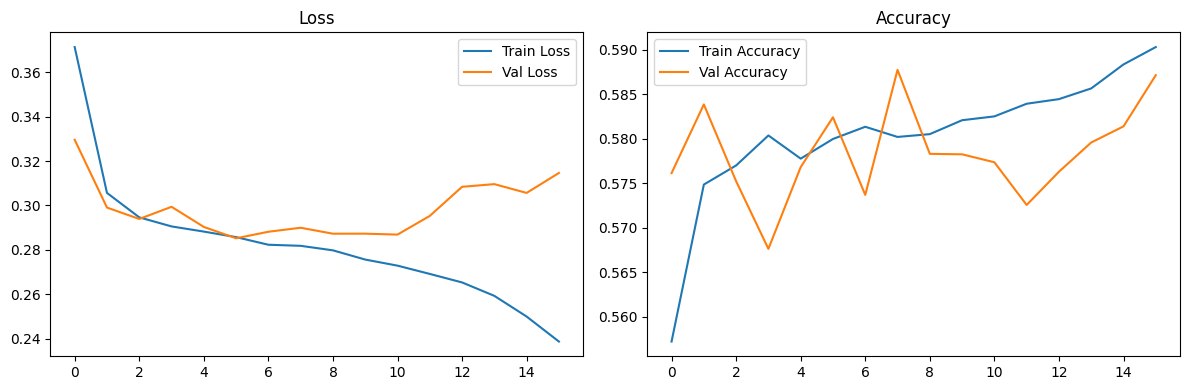

In [ ]:
# Ploting Training History

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [ ]:
# Calculate IOU, Dice Score and Accuracy on validation set
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    
    # Calculate metrics
    accuracy = np.mean(y_true == y_pred_binary)
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    
    return accuracy, dice, iou

In [15]:
# Evaluate on validation set
print("Evaluating model on validation set...")
validation_predictions = model.predict(X_test)
val_accuracy, val_dice, val_iou = calculate_metrics(y_test, validation_predictions)

print(f"Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Dice Score: {val_dice:.4f}")
print(f"IoU Score: {val_iou:.4f}")


Evaluating model on validation set...
59/59 [==============================] - 6s 110ms/step
Validation Metrics:
Accuracy: 0.5824
Dice Score: 0.8046
IoU Score: 0.6730


### Third Approach

In [ ]:
# Improved U-Net Architecture

def encoder_block(inputs, num_filters):
    """Encoder block with convolution, activation, and max pooling."""
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)  
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)  # Reduce dimensions
    
    return x, p  # Return feature map and pooled version for next layer

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block with transposed convolution and concatenation."""
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)

    # Ensure skip connection dimensions match
    crop_size = (skip_features.shape[1] - x.shape[1]) // 2  # Crop extra pixels
    skip_features = tf.keras.layers.Cropping2D(crop_size)(skip_features)

    x = tf.keras.layers.Concatenate()([x, skip_features])  # Merge
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

def unet_model(input_shape=(128, 128, 3), num_classes=1):
    """Full U-Net model combining encoder and decoder blocks."""
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder Path (Contracting)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(p4)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Decoder Path (Expanding)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid', padding='same')(d4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

model = unet_model()
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [5]:
# Define image size
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Function to load and preprocess images
def load_data(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    images, masks = [], []

    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Resize
        img = img / 255.0  # Normalize
        images.append(img)

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))  # Resize
        mask = mask / 255.0  # Normalize
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

In [6]:
X, y = load_data(IMAGE_DIR, MASK_DIR)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
# Training


batch_size = 16

print("Training model...")
steps_per_epoch = len(X_train) // batch_size
history = model.fit(
    X_train, y_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, y_test),
    epochs=50,
)



Training model...
Epoch 1/50
469/469 [==============================] - 167s 290ms/step - loss: 0.3036 - accuracy: 0.5752 - mean_io_u: 0.4973 - val_loss: 0.3645 - val_accuracy: 0.6064 - val_mean_io_u: 0.4973
Epoch 2/50
469/469 [==============================] - 128s 273ms/step - loss: 0.2700 - accuracy: 0.5852 - mean_io_u: 0.4973 - val_loss: 0.2854 - val_accuracy: 0.5965 - val_mean_io_u: 0.4973
Epoch 3/50
469/469 [==============================] - 128s 272ms/step - loss: 0.2678 - accuracy: 0.5843 - mean_io_u: 0.4973 - val_loss: 0.2709 - val_accuracy: 0.5909 - val_mean_io_u: 0.4973
Epoch 4/50
469/469 [==============================] - 128s 272ms/step - loss: 0.2668 - accuracy: 0.5861 - mean_io_u: 0.4973 - val_loss: 0.2742 - val_accuracy: 0.5922 - val_mean_io_u: 0.4973
Epoch 5/50
469/469 [==============================] - 140s 299ms/step - loss: 0.2632 - accuracy: 0.5861 - mean_io_u: 0.4972 - val_loss: 0.2732 - val_accuracy: 0.5926 - val_mean_io_u: 0.4973
Epoch 6/50
469/469 [============

In [ ]:
model.save("unet_face_mask.h5")     # Saving model

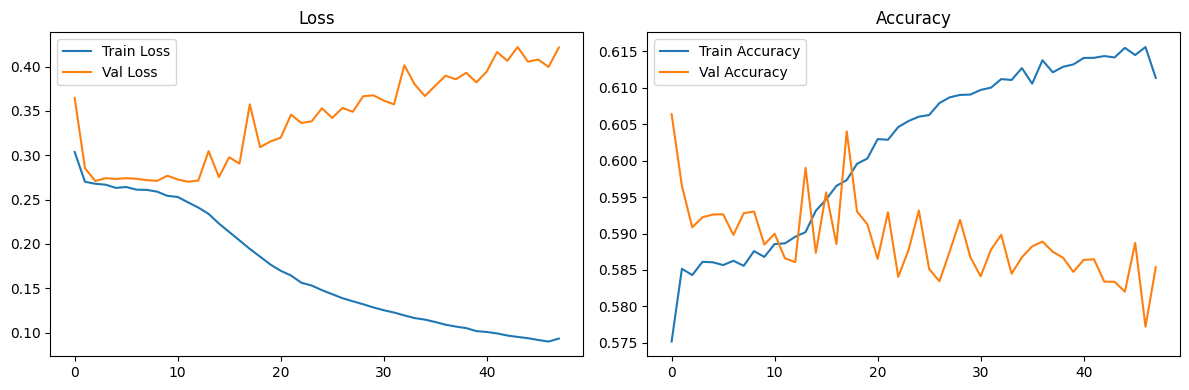

In [ ]:
# Plot Training History

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [ ]:
# Improved computation metrics

def dice_coef(y_true, y_pred, smooth=1):
    """Compute Dice Score (F1-score for segmentation)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Compute Intersection over Union (IoU)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Calculate Accuracy, Dice Score, and IoU"""
    y_pred_binary = (y_pred > threshold).astype(np.float32)  # Ensure binary mask

    accuracy = np.mean((y_true == y_pred_binary).astype(np.float32))
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    
    return accuracy, dice, iou


In [21]:
# Evaluate on validation set
print("Evaluating model on validation set...")
validation_predictions = model.predict(X_test)
val_accuracy, val_dice, val_iou = calculate_metrics(y_test, validation_predictions)

print(f"Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Dice Score: {val_dice:.4f}")
print(f"IoU Score: {val_iou:.4f}")


Evaluating model on validation set...
59/59 [==============================] - 15s 243ms/step
Validation Metrics:
Accuracy: 0.5854
Dice Score: 0.8665
IoU Score: 0.7644


### Fourth Approach

In [6]:


def encoder_block(inputs, num_filters):
    """Encoder block with convolution, activation, and max pooling."""
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)  
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)  # Reduce dimensions
    
    return x, p  # Return feature map and pooled version for next layer

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block with transposed convolution and concatenation."""
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)

    # Ensure skip connection dimensions match
    crop_size = (skip_features.shape[1] - x.shape[1]) // 2  # Crop extra pixels
    skip_features = tf.keras.layers.Cropping2D(crop_size)(skip_features)

    x = tf.keras.layers.Concatenate()([x, skip_features])  # Merge
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    
    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(drop4), conv3], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint('unet_face_mask.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [8]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [ ]:
# Loss Functions: Dice Loss

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [10]:
# Compile model (using Dice Loss)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

In [11]:
batch_size = 16

# Training

print("Training model...")
steps_per_epoch = len(X_train) // batch_size
history = model.fit(
    X_train, y_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

Training model...
Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.4650 - mean_io_u: 0.3791
Epoch 1: val_loss improved from inf to 0.19983, saving model to unet_face_mask.keras
469/469 [==============================] - 182s 299ms/step - loss: 0.2738 - accuracy: 0.4650 - mean_io_u: 0.3791 - val_loss: 0.1998 - val_accuracy: 0.5631 - val_mean_io_u: 0.3927 - lr: 1.0000e-04
Epoch 2/20
469/469 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.5600 - mean_io_u: 0.3932
Epoch 2: val_loss improved from 0.19983 to 0.19705, saving model to unet_face_mask.keras
469/469 [==============================] - 80s 170ms/step - loss: 0.2007 - accuracy: 0.5600 - mean_io_u: 0.3932 - val_loss: 0.1971 - val_accuracy: 0.5570 - val_mean_io_u: 0.3618 - lr: 1.0000e-04
Epoch 3/20
469/469 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.5629 - mean_io_u: 0.3913
Epoch 3: val_loss improved from 0.19705 to 0.19376, saving model to u

In [12]:
model.save("unet_face_mask_2.h5")

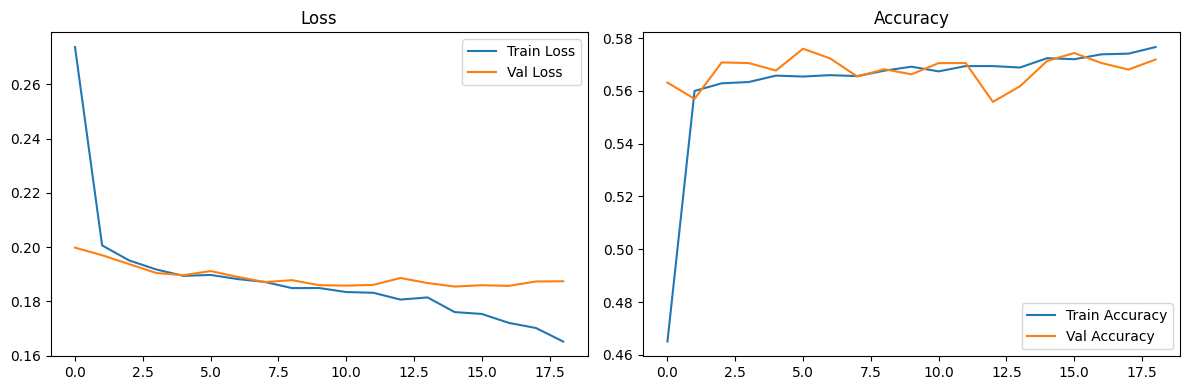

In [16]:
# Plot Training History

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [14]:

def dice_coef(y_true, y_pred, smooth=1):
    """Compute Dice Score (F1-score for segmentation)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Compute Intersection over Union (IoU)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Calculate Accuracy, Dice Score, and IoU"""
    y_pred_binary = (y_pred > threshold).astype(np.float32)  # Ensure binary mask

    accuracy = np.mean((y_true == y_pred_binary).astype(np.float32))
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    
    return accuracy, dice, iou


In [15]:
# Evaluate on validation set
print("Evaluating model on validation set...")
validation_predictions = model.predict(X_test)
val_accuracy, val_dice, val_iou = calculate_metrics(y_test, validation_predictions)

print(f"Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Dice Score: {val_dice:.4f}")
print(f"IoU Score: {val_iou:.4f}")


Evaluating model on validation set...
59/59 [==============================] - 4s 75ms/step
Validation Metrics:
Accuracy: 0.5719
Dice Score: 0.8902
IoU Score: 0.8021


# Example Usage

1/1 [==============================] - 1s 596ms/step


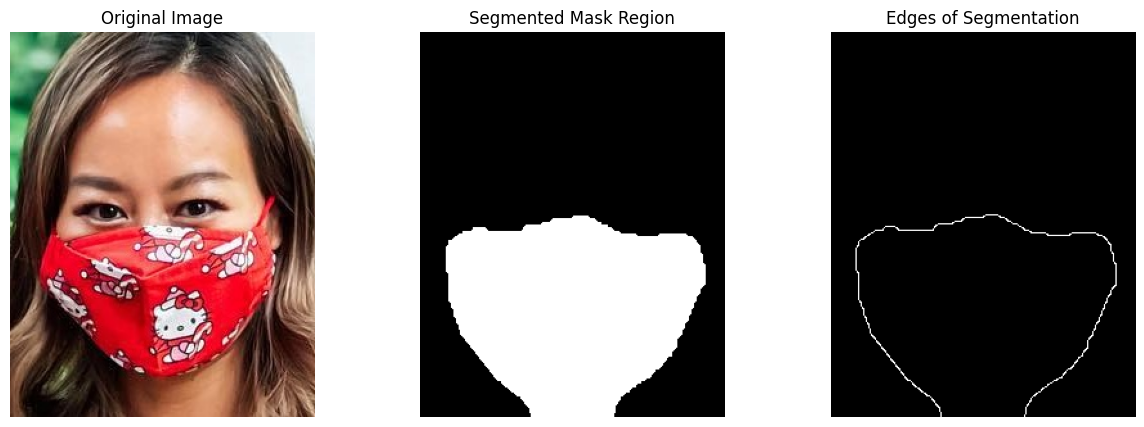

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load the trained model
model = tf.keras.models.load_model("unet_face_mask_2.h5", compile=False) 

# Function to preprocess image for the model
def preprocess_image(image_path, target_size=(128, 128)): 
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, target_size)  # Resizing
    image_normalized = image_resized / 255.0  # Normalizing
    return image, np.expand_dims(image_normalized, axis=0) 

# Function to segment and visualize
def segment_mask_region(image_path, viz=True, to_save=False, save_path=None):
    # Load and preprocess image
    original_image, input_img = preprocess_image(image_path)

    # Predict the segmentation mask using the model
    predicted_mask = model.predict(input_img)[0] 

    # Convert predicted mask to binary
    segmented_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Convert mask to display format (0-255 range)
    segmented_display = (segmented_mask * 255).astype(np.uint8)
    segmented_display = cv2.resize(segmented_display, (original_image.shape[1], original_image.shape[0]))

    # Ensure binary segmentation before Canny
    segmented_display = cv2.threshold(segmented_display, 127, 255, cv2.THRESH_BINARY)[1]

    # Morphological Closing to Refine Segmentation
    kernel = np.ones((5, 5), np.uint8)
    segmented_display = cv2.morphologyEx(segmented_display, cv2.MORPH_CLOSE, kernel)

    # Apply Canny Edge Detection
    edges = cv2.Canny(segmented_display, 50, 150)

    if viz:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display Original Image
        axes[0].imshow(original_image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # Display Segmented Region
        axes[1].imshow(segmented_display, cmap="gray", vmin=0, vmax=255)
        axes[1].set_title("Segmented Mask Region")
        axes[1].axis("off")

        # Display Edge Detection Result
        axes[2].imshow(edges, cmap="gray", vmin=0, vmax=255)
        axes[2].set_title("Edges of Segmentation")
        axes[2].axis("off")

        plt.show()
    

    return segmented_display

# Example usage
segment_mask_region("000030_2.jpg")
